<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/bullriding_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap --quiet
!pip install adjustText --quiet

     |████████████████████████████████| 358kB 5.1MB/s 


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import lightgbm as lgb
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score
from sklearn.preprocessing import StandardScaler,scale
from adjustText import adjust_text

import shap
sns.set_context('talk')
shap.initjs()

In [ ]:
project_dir = "/content/drive/My Drive/bullriding"

# things i want to do this time

1. rider + bull success probability
whether or not a rider will make 8s  

2. rider + bull + judge score estimate/distribution  
estimate how many points are scored  
create a score over expected statistic  

3. bull draft  
is there some bull-specific metrics we can come up with to better draft bulls?  

## data dict  
each row is a bull  
`rank`: ranking among all bulls  
`avgmark`: avg bull score  
`adjavg`: adjustment based on level  
`pavg`: PBR avg  
`bavg`: CBR avg ("B" events)  
`mounted`: attempted rides  
`rode`: qualified rides  
`vtg*`: versus the best riders  
`vsr*`: versus right-handed riders  
`vsl*`: versus left-handed riders  
`dirpref`: the estimated preferred direction the bull spins  
`dirperc`: percentage the bull spins in the preferred direction  
`power`: performances + difficulty  
`winperc`: percentage of the time they are the highest marked bull in the round  
`rawrank`: temp column based on rank   
`arank`: rank among active bulls   

In [ ]:
fns = [f"{project_dir}/data/{x}" for x in ['guystats.csv',
                                           'nickwan_bulls.csv',
                                           'rides_2015_to_present.csv']]

In [ ]:
guystats = pd.read_csv(fns[0])
for col in ['rode', 'fmounted', 'frode', 'num85']:
  guystats[f"{col}%"] = guystats[col].div(guystats['mounted'])
guystats.head()

,guy,records,mounted,rode,fmounted,frode,num85,hisc,ppo,streak,winperc,bullrank,bullpower,hand,ht,wt,note,pbrid,guyid,rode%,fmounted%,frode%,num85%
0,Aaron Atkinson,20,18,2,0,0,1,88.0,79.500,0.00,0.000,12913,61.88,NaN,70,165,NaN,1770,1,0.111111,0.000000,0.0,0.055556
1,Aaron Bean,14,14,1,1,0,0,70.0,70.000,0.00,0.000,10988,68.69,NaN,70,185,NaN,3854,2,0.071429,0.071429,0.0,0.000000
2,Aaron Blendell,3,1,0,0,0,0,0.0,0.000,0.00,0.000,4142,76.80,NaN,0,0,NaN,0,3,0.000000,0.000000,0.0,0.000000
3,Aaron Brewer,158,152,39,3,0,7,89.0,76.256,6.67,0.026,11193,55.66,L,72,145,NaN,0,4,0.256579,0.019737,0.0,0.046053
4,Aaron Brookshire,4,4,0,0,0,0,0.0,0.000,0.00,0.000,4396,64.78,NaN,0,0,NaN,0,5,0.000000,0.000000,0.0,0.000000


In [ ]:
nickwan_bulls = pd.read_csv(fns[1])
for col in ['rode', 'vtgbo', 'vtgrode', 'vslbo', 'vslrode', 'vsrbo', 'vsrrode']:
  nickwan_bulls[f"{col}%"] = nickwan_bulls[col].div(nickwan_bulls['mounted'])
nickwan_bulls.head()

,rank,pbid,bno,bname,avgmark,mounted,rode,vtgbo,vtgrode,vslbo,vslrode,vsrbo,vsrrode,dirpref,dirperc,power,rode%,vtgbo%,vtgrode%,vslbo%,vslrode%,vsrbo%,vsrrode%
0,23,31396,32Y,SweetPro's Bruiser,22.677,133,29,74,25,43,17,50,12,left,9.0,86.53,0.218045,0.556391,0.187970,0.323308,0.127820,0.375940,0.090226
1,36,42345,524,Cliffhanger,22.560,7,0,1,0,2,0,3,0,unknown,0.0,76.90,0.000000,0.142857,0.000000,0.285714,0.000000,0.428571,0.000000
2,39,26210,849,Crystal Deal,22.536,46,6,13,6,13,1,17,5,right,16.0,80.48,0.130435,0.282609,0.130435,0.282609,0.021739,0.369565,0.108696
3,47,40393,43C-,Chiseled,22.457,40,11,14,11,10,3,17,8,right,9.0,79.98,0.275000,0.350000,0.275000,0.250000,0.075000,0.425000,0.200000
4,70,38961,F50,Wild Onion,22.371,22,1,5,1,8,1,7,0,left,11.0,75.14,0.045455,0.227273,0.045455,0.363636,0.045455,0.318182,0.000000


In [ ]:
rides = pd.read_csv(fns[2])
rides.sample(10)

,guyid,year,pbid,rid,perf,contestant,sc,ja,jb,time,go,comments,mid,qr,isout
58364,6256,2018,35181,R3843,05,Tyler Taylor,0.0,21.00,19.00,4.38,2,*,416111,0,1
83714,7721,2020,42739,AB459,02,Jess Lockwood,90.5,21.50,21.75,8.00,2,*,444106,1,1
10234,7015,2015,32846,AC809,02,Alex Lee,0.0,21.00,20.50,6.54,1,*,362470,0,1
90108,9112,2020,40629,XT166,01,Chauk Dees,0.0,22.00,22.50,3.30,1,*,451925,0,1
2729,5629,2015,30051,AB323,03,Tanner Byrne,0.0,21.75,22.50,1.82,3,*,353956,0,1
12861,3471,2015,28031,R3370,02,Tag Elliott,0.0,18.00,19.00,3.80,1,*,365376,0,1
20209,6727,2015,30798,AB341,05,Jay Miller,0.0,21.00,20.75,5.52,5,*,373876,0,1
38804,6850,2016,32366,R3684,03,Lex Oakley,0.0,22.50,22.50,4.00,1,(nmb)(nt),394646,0,1
8892,3795,2015,32252,AN149,01F,Aaron Roy,85.5,21.50,21.00,8.00,F,*,360942,1,1
26797,2408,2016,28859,AB351,03F,Mike Lee,0.0,22.50,22.75,6.44,F,*,381258,0,1


In [ ]:
rides.loc[rides['sc']==0].shape[0]

68336

In [ ]:
rides.loc[rides['sc']!=0].shape[0]

24804

In [ ]:
rides.loc[rides['sc']!=0].shape[0]/rides.shape[0]

0.2663087824779901

In [ ]:
guystats.loc[guystats['guy'].str.contains('Leme')]

,guy,records,mounted,rode,fmounted,frode,num85,hisc,ppo,streak,winperc,bullrank,bullpower,hand,ht,wt,note,pbrid,guyid,rode%,fmounted%,frode%,num85%
2438,Mike Lemen,4,2,2,0,0,0,77.00,76.000,0.00,0.000,14309,45.36,NaN,0,0,NaN,0,2409,1.00000,0.00000,0.000000,0.000000
8220,Jose Vitor Leme,356,339,206,67,43,175,95.75,87.414,33.33,0.242,2745,73.80,L,66,139,NaN,2108669,8288,0.60767,0.19764,0.126844,0.516224


In [ ]:
guystats.loc[guystats['guy'].str.contains('Leme')]

,guy,records,mounted,rode,fmounted,frode,num85,hisc,ppo,streak,winperc,bullrank,bullpower,hand,ht,wt,note,pbrid,guyid,rode%,fmounted%,frode%,num85%
2438,Mike Lemen,4,2,2,0,0,0,77.00,76.000,0.00,0.000,14309,45.36,NaN,0,0,NaN,0,2409,1.00000,0.00000,0.000000,0.000000
8220,Jose Vitor Leme,356,339,206,67,43,175,95.75,87.414,33.33,0.242,2745,73.80,L,66,139,NaN,2108669,8288,0.60767,0.19764,0.126844,0.516224


In [ ]:
[x for x in rides.columns.values if x in guystats.columns.values]

['guyid']

In [ ]:
nickwan_bulls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3890 entries, 0 to 3889
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rank      3890 non-null   int64  
 1   pbid      3890 non-null   int64  
 2   bno       3890 non-null   object 
 3   bname     3890 non-null   object 
 4   avgmark   3890 non-null   float64
 5   mounted   3890 non-null   int64  
 6   rode      3890 non-null   int64  
 7   vtgbo     3890 non-null   int64  
 8   vtgrode   3890 non-null   int64  
 9   vslbo     3890 non-null   int64  
 10  vslrode   3890 non-null   int64  
 11  vsrbo     3890 non-null   int64  
 12  vsrrode   3890 non-null   int64  
 13  dirpref   3890 non-null   object 
 14  dirperc   3890 non-null   float64
 15  power     3890 non-null   float64
 16  rode%     3890 non-null   float64
 17  vtgbo%    3890 non-null   float64
 18  vtgrode%  3890 non-null   float64
 19  vslbo%    3890 non-null   float64
 20  vslrode%  3890 non-null   floa

In [ ]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93140 entries, 0 to 93139
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   guyid       93140 non-null  int64  
 1   year        93140 non-null  int64  
 2   pbid        93140 non-null  int64  
 3   rid         93140 non-null  object 
 4   perf        93140 non-null  object 
 5   contestant  93140 non-null  object 
 6   sc          93140 non-null  float64
 7   ja          93140 non-null  float64
 8   jb          93140 non-null  float64
 9   time        93140 non-null  float64
 10  go          93140 non-null  object 
 11  comments    93137 non-null  object 
 12  mid         93140 non-null  int64  
 13  qr          93140 non-null  int64  
 14  isout       93140 non-null  int64  
dtypes: float64(4), int64(6), object(5)
memory usage: 10.7+ MB


In [ ]:
data = rides.merge(nickwan_bulls).merge(guystats, on=['guyid'], suffixes=('_bull', '_guy'))
data.loc[:, 'make8'] = 0
data.loc[data['sc']>0, 'make8'] = 1
data = data.merge(pd.get_dummies(data['dirpref']).add_prefix('bulldir_'), left_index=True, right_index=True)
data['rider_left'] = 1
data.loc[data['hand']=='R', 'rider_left'] = 0
data.shape

(62412, 64)

In [ ]:
data['hand'].value_counts()

R    27480
L    21037
Name: hand, dtype: int64

In [ ]:
data['dirpref'].astype('category').cat.codes

0        0
1        0
2        2
3        1
4        0
        ..
62407    2
62408    2
62409    0
62410    2
62411    2
Length: 62412, dtype: int8

In [ ]:
data.loc[data['wt']!=0].shape

(14013, 64)

In [ ]:
data.columns.values

array(['guyid', 'year', 'pbid', 'rid', 'perf', 'contestant', 'sc', 'ja',
       'jb', 'time', 'go', 'comments', 'mid', 'qr', 'isout', 'rank',
       'bno', 'bname', 'avgmark', 'mounted_bull', 'rode_bull', 'vtgbo',
       'vtgrode', 'vslbo', 'vslrode', 'vsrbo', 'vsrrode', 'dirpref',
       'dirperc', 'power', 'rode%_bull', 'vtgbo%', 'vtgrode%', 'vslbo%',
       'vslrode%', 'vsrbo%', 'vsrrode%', 'guy', 'records', 'mounted_guy',
       'rode_guy', 'fmounted', 'frode', 'num85', 'hisc', 'ppo', 'streak',
       'winperc', 'bullrank', 'bullpower', 'hand', 'ht', 'wt', 'note',
       'pbrid', 'rode%_guy', 'fmounted%', 'frode%', 'num85%', 'make8',
       'bulldir_left', 'bulldir_right', 'bulldir_unknown', 'rider_left'],
      dtype=object)

In [ ]:
make8_rider_feats = ['year', 'rode%_guy', 'fmounted%', 'frode%',
                     'num85%','rider_left']
make8_bull_feats = ['power', 'hisc', 'rode%_bull', 'vtgbo%', 'vtgrode%',
                    'vslbo%', 'vslrode%', 'vsrbo%', 'vsrrode%', 'bulldir_left',
                    'bulldir_right', 'bulldir_unknown']
make8_target = 'make8'
make8_model_data = data.loc[:, ['guyid'] + make8_rider_feats + make8_bull_feats + [make8_target]]
make8_model_data.sample(5)

,guyid,year,rode%_guy,fmounted%,frode%,num85%,rider_left,power,hisc,rode%_bull,vtgbo%,vtgrode%,vslbo%,vslrode%,vsrbo%,vsrrode%,bulldir_left,bulldir_right,bulldir_unknown,make8
38729,5061,2017,0.185000,0.085000,0.010000,0.095000,0,89.41,88.00,0.086207,0.620690,0.086207,0.413793,0.068966,0.448276,0.017241,1,0,0,0
45182,5360,2016,0.227273,0.189394,0.037879,0.128788,1,71.73,88.50,0.307692,0.230769,0.038462,0.153846,0.115385,0.230769,0.115385,1,0,0,1
33657,5183,2019,0.250000,0.154605,0.032895,0.134868,0,59.82,89.00,0.388889,0.222222,0.277778,0.277778,0.055556,0.166667,0.333333,0,1,0,0
51723,8385,2019,0.102564,0.051282,0.000000,0.000000,1,83.08,76.00,0.250000,0.526316,0.210526,0.250000,0.078947,0.407895,0.157895,0,1,0,0
2913,3930,2015,0.409651,0.158111,0.056468,0.265914,1,85.91,93.25,0.217949,0.717949,0.217949,0.410256,0.179487,0.346154,0.038462,1,0,0,0


In [ ]:
df_pred = pd.DataFrame()
kf = GroupKFold(10)
for train_idx, test_idx in kf.split(make8_model_data, groups=make8_model_data['guyid']):
  train_data = make8_model_data.iloc[train_idx].copy()
  test_data = make8_model_data.iloc[test_idx].copy()
  model = LogisticRegression(max_iter=300)
  model.fit(train_data.loc[:, make8_rider_feats + make8_bull_feats], train_data[make8_target])
  test_data['make8_prob'] = pd.DataFrame(model.predict_proba(test_data.loc[:, make8_rider_feats + make8_bull_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)
df_pred.shape

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


(62412, 21)

In [ ]:
log_loss(df_pred[make8_target], np.repeat([df_pred[make8_target].mean()],
                                          df_pred[make8_target].shape[0]))

0.5692331352703018

In [ ]:
log_loss(df_pred[make8_target], df_pred[f"{make8_target}_prob"])

0.45195221793865353

In [ ]:
accuracy_score(df_pred[make8_target], np.round(np.repeat([df_pred[make8_target].mean()],
                                          df_pred[make8_target].shape[0])))

0.7436230212138691

In [ ]:
accuracy_score(df_pred[make8_target], df_pred[f"{make8_target}_prob"].round(0))

0.7819650067294751

In [ ]:
sc_rider_feats = ['year', 'rode%_guy', 'fmounted%', 'frode%',
                  'num85%','rider_left']
sc_bull_feats = ['power', 'hisc', 'rode%_bull', 'vtgbo%', 'vtgrode%',
                 'vslbo%', 'vslrode%', 'vsrbo%', 'vsrrode%', 'bulldir_left',
                 'bulldir_right', 'bulldir_unknown']
sc_target = 'sc'
sc_model_data = data.loc[data['make8']==1, ['guyid'] + sc_rider_feats + sc_bull_feats + [sc_target]]
sc_model_data_holdout = data.loc[data['make8']==0, ['guyid'] + sc_rider_feats + sc_bull_feats + [sc_target]]
sc_model_data.sample(5)

,guyid,year,rode%_guy,fmounted%,frode%,num85%,rider_left,power,hisc,rode%_bull,vtgbo%,vtgrode%,vslbo%,vslrode%,vsrbo%,vsrrode%,bulldir_left,bulldir_right,bulldir_unknown,sc
2270,6385,2015,0.449585,0.162515,0.052195,0.316726,0,82.27,93.75,0.250000,0.416667,0.187500,0.270833,0.062500,0.416667,0.187500,0,1,0,85.75
13077,690,2017,0.333333,0.158206,0.041455,0.182741,0,51.61,92.00,0.615385,0.076923,0.307692,0.000000,0.307692,0.192308,0.307692,1,0,0,87.00
58961,3044,2016,0.293151,0.123288,0.035616,0.112329,0,38.13,91.00,0.555556,0.000000,0.111111,0.111111,0.333333,0.222222,0.222222,0,0,1,84.50
1826,5251,2017,0.507797,0.163743,0.073099,0.269981,0,59.79,92.50,0.285714,0.214286,0.214286,0.071429,0.000000,0.428571,0.285714,0,0,1,85.00
44349,6400,2018,0.300836,0.047354,0.008357,0.050139,0,39.87,93.00,0.333333,0.000000,0.000000,0.166667,0.000000,0.000000,0.333333,0,0,1,84.50


In [ ]:
df_pred2 = pd.DataFrame()
kf = GroupKFold(10)
for train_idx, test_idx in kf.split(sc_model_data, groups=sc_model_data['guyid']):
  train_data = sc_model_data.iloc[train_idx].copy()
  test_data = sc_model_data.iloc[test_idx].copy()
  model = LinearRegression()
  model.fit(train_data.loc[:, sc_rider_feats + sc_bull_feats], train_data[sc_target])
  test_data[f'{sc_target}_pred'] = pd.Series(model.predict(test_data.loc[:, sc_rider_feats + sc_bull_feats]), index=test_data.index)
  df_pred2 = df_pred2.append(test_data)
df_pred2.shape

(16001, 21)

In [ ]:
model = LinearRegression()
model.fit(sc_model_data.loc[:, sc_rider_feats + sc_bull_feats], sc_model_data[sc_target])
sc_model_data_holdout[f'{sc_target}_pred'] = pd.Series(model.predict(sc_model_data_holdout.loc[:, sc_rider_feats + sc_bull_feats]), index=sc_model_data_holdout.index)
df_pred2 = df_pred2.append(sc_model_data_holdout)
df_pred2.shape

(62412, 21)

In [ ]:
data['make8_prob'] = df_pred['make8_prob']
data['sc_pred'] = df_pred2['sc_pred']
data.shape

(62412, 66)

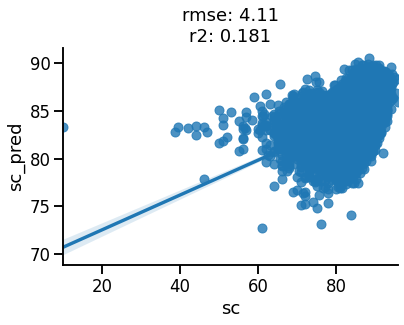

In [ ]:
rmse = mean_squared_error(data.loc[data['make8']==1, sc_target], data.loc[data['make8']==1, f"{sc_target}_pred"])**0.5
r2 = pearsonr(data.loc[data['make8']==1, sc_target], data.loc[data['make8']==1, f"{sc_target}_pred"])[0]**2

df_plt = data.loc[data['make8']==1]
sns.regplot(x=sc_target, y=f"{sc_target}_pred", data=df_plt)
plt.title(f"rmse: {round(rmse,3)}\nr2: {round(r2,3)}")
sns.despine()
plt.show()

In [ ]:
guystats.loc[guystats['guy']=='Dalton Kasel']

,guy,records,mounted,rode,fmounted,frode,num85,hisc,ppo,streak,winperc,bullrank,bullpower,hand,ht,wt,note,pbrid,guyid,rode%,fmounted%,frode%,num85%
8832,Dalton Kasel,111,108,39,21,5,36,93.0,87.929,46.67,0.13,3333,73.26,L,0,0,NaN,3810792,8924,0.361111,0.194444,0.046296,0.333333


In [ ]:
nickwan_bulls.loc[nickwan_bulls['bname']=='Fearless']

,rank,pbid,bno,bname,avgmark,mounted,rode,vtgbo,vtgrode,vslbo,vslrode,vsrbo,vsrrode,dirpref,dirperc,power,rode%,vtgbo%,vtgrode%,vslbo%,vslrode%,vsrbo%,vsrrode%
26,192,40032,23B,Fearless,22.005,54,7,31,6,18,5,25,2,left,14.0,89.05,0.12963,0.574074,0.111111,0.333333,0.092593,0.462963,0.037037


In [ ]:
data.loc[:, ['year', 'contestant', 'bname', 'time', 'make8', 'sc', 'make8_prob', 'sc_pred']].sample(10)

,year,contestant,bname,time,make8,sc,make8_prob,sc_pred
58091,2015,Clint Miller,Muddy Chicken,4.00,0,0.0,0.093135,83.742345
57714,2016,Aukai Kaai,Captain Call,3.50,0,0.0,0.000012,59.857697
11865,2019,Trevor Kastner,Gritty,1.90,0,0.0,0.268868,84.022838
42053,2018,Lon Danley,Fur'd Up Cookie,4.00,0,0.0,0.174829,81.526593
60165,2020,Money Crist,Night Watchman,3.10,0,0.0,0.000017,59.242597
700,2019,Taylor Toves,Western Skies,2.84,0,0.0,0.103797,84.109138
1309,2016,Sean Willingham,Dairy Gold,8.00,1,86.0,0.773783,83.526491
37860,2020,Shad Winn,Danger Danger,8.00,1,74.0,0.549105,79.103654
16226,2016,Chase Outlaw,Pozzy Time,8.00,1,84.0,0.657269,86.807638
50036,2018,Jeff Bertus,Montana Moon,2.19,0,0.0,0.176851,80.857692


In [ ]:
data['sc_over_expected'] = data['sc'].sub(data['sc_pred'])
data['make8_over_expected'] = data['make8'].sub(data['make8_prob'])

In [ ]:
_agg1 = data.loc[:, ['year','guyid', 'guy', 'sc_over_expected']].groupby(['year','guyid', 'guy'], as_index=False).count().rename(columns={'sc_over_expected':'outs'})
_agg2 = data.loc[data['make8']==1, ['year','guyid', 'guy', 'sc_over_expected', 'make8_over_expected']].groupby(['year','guyid', 'guy'], as_index=False).sum()
df_agg = _agg1.merge(_agg2)
for col in ['sc_over_expected', 'make8_over_expected']:
  df_agg[f"{col}_mean"] = df_agg[col].div(df_agg['outs'])
df_agg.shape

(2260, 8)

In [ ]:
make8_rider_feats

['year', 'rode%_guy', 'fmounted%', 'frode%', 'num85%', 'rider_left']

In [ ]:
rider = 'Jose Vitor Leme'
guystats.loc[guystats['guy']==rider]

,guy,records,mounted,rode,fmounted,frode,num85,hisc,ppo,streak,winperc,bullrank,bullpower,hand,ht,wt,note,pbrid,guyid,rode%,fmounted%,frode%,num85%
8220,Jose Vitor Leme,356,339,206,67,43,175,95.75,87.414,33.33,0.242,2745,73.8,L,66,139,NaN,2108669,8288,0.60767,0.19764,0.126844,0.516224


In [ ]:
bull = 'Safety Meeting'
nickwan_bulls.loc[nickwan_bulls['bname']==bull]

,rank,pbid,bno,bname,avgmark,mounted,rode,vtgbo,vtgrode,vslbo,vslrode,vsrbo,vsrrode,dirpref,dirperc,power,rode%,vtgbo%,vtgrode%,vslbo%,vslrode%,vsrbo%,vsrrode%
70,354,40913,51,Safety Meeting,21.833,34,11,9,11,11,8,9,3,left,17.0,71.2,0.323529,0.264706,0.323529,0.323529,0.235294,0.264706,0.088235


In [ ]:
data.loc[(data['guy']==rider) & (data['bname']==bull), ['year', 'contestant', 'bname', 'time', 'make8', 'sc', 'make8_prob', 'sc_pred']]

,year,contestant,bname,time,make8,sc,make8_prob,sc_pred
6090,2020,Jose Vitor Leme,Safety Meeting,8.0,1,90.00,0.673914,89.256238
6091,2020,Jose Vitor Leme,Safety Meeting,8.0,1,89.25,0.673914,89.256238


In [ ]:
df_agg[['outs']].describe()

,outs
count,2260.000000
mean,23.722124
std,23.454849
min,1.000000
25%,7.000000
50%,15.000000
75%,33.000000
max,149.000000


In [ ]:
data.loc[:, make8_rider_feats].sample(5)

,year,rode%_guy,fmounted%,frode%,num85%,rider_left
37109,2019,0.075556,0.071111,0.000000,0.004444,1
23731,2016,0.340708,0.182891,0.039823,0.231563,0
60814,2019,0.166667,0.133333,0.000000,0.033333,1
35559,2016,0.372121,0.132121,0.050909,0.261818,0
53849,2016,0.292517,0.047619,0.013605,0.136054,0


In [ ]:
leme = guystats.loc[guystats['guy']=='Jose Vitor Leme']
leme

,guy,records,mounted,rode,fmounted,frode,num85,hisc,ppo,streak,winperc,bullrank,bullpower,hand,ht,wt,note,pbrid,guyid,rode%,fmounted%,frode%,num85%
8220,Jose Vitor Leme,356,339,206,67,43,175,95.75,87.414,33.33,0.242,2745,73.8,L,66,139,NaN,2108669,8288,0.60767,0.19764,0.126844,0.516224


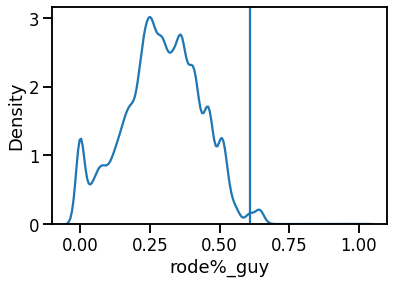

In [ ]:
col = 'rode%'
sns.kdeplot(data.loc[:, f'{col}_guy'])
plt.axvline(leme[col].values[0])

,sc_over_expected
count,2260.000000
mean,0.049350
std,14.552655
min,-103.976967
25%,-5.067856
50%,1.049717
75%,5.218441
max,126.704672


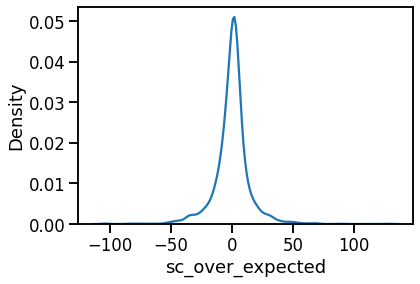

In [ ]:
sns.kdeplot(df_agg['sc_over_expected'])
df_agg[['sc_over_expected']].describe()

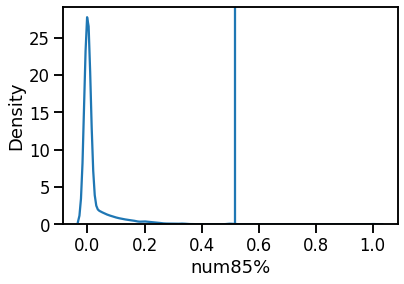

In [ ]:
sns.kdeplot(guystats['num85%'])
plt.axvline(guystats.loc[guystats['guy']=='Jose Vitor Leme', 'num85%'].values[0])

In [ ]:
guystats.loc[guystats['guy'].isin(['Sage Kimzey', 'Jose Vitor Leme'])]

,guy,records,mounted,rode,fmounted,frode,num85,hisc,ppo,streak,winperc,bullrank,bullpower,hand,ht,wt,note,pbrid,guyid,rode%,fmounted%,frode%,num85%
6681,Sage Kimzey,844,767,494,96,60,294,94.00,84.450,53.33,0.168,5936,64.96,R,0,0,NaN,6360,6685,0.644068,0.125163,0.078227,0.383312
8220,Jose Vitor Leme,356,339,206,67,43,175,95.75,87.414,33.33,0.242,2745,73.80,L,66,139,NaN,2108669,8288,0.607670,0.197640,0.126844,0.516224


In [ ]:
df_agg.loc[(df_agg['guy']=='Jose Vitor Leme') & (df_agg['outs']>=75)].sort_values(['sc_over_expected'], ascending=False)

,year,guyid,guy,outs,sc_over_expected,make8_over_expected,sc_over_expected_mean,make8_over_expected_mean
1480,2018,8288,Jose Vitor Leme,84,-26.564024,17.856240,-0.316238,0.212574
2136,2020,8288,Jose Vitor Leme,91,-27.394060,23.555112,-0.301034,0.258847
1828,2019,8288,Jose Vitor Leme,128,-44.910271,28.760730,-0.350861,0.224693


In [ ]:
df_agg.loc[(df_agg['guy']=='Sage Kimzey') & (df_agg['outs']>=75)].sort_values(['sc_over_expected'], ascending=False)

,year,guyid,guy,outs,sc_over_expected,make8_over_expected,sc_over_expected_mean,make8_over_expected_mean
985,2017,6685,Sage Kimzey,96,126.704672,23.984740,1.319840,0.249841
641,2016,6685,Sage Kimzey,90,51.501441,20.574924,0.572238,0.228610


In [ ]:
df_agg.loc[df_agg['outs']>=75].sort_values('sc_over_expected', ascending=False).tail(20)

,year,guyid,guy,outs,sc_over_expected,make8_over_expected,sc_over_expected_mean,make8_over_expected_mean
1480,2018,8288,Jose Vitor Leme,84,-26.564024,17.856240,-0.316238,0.212574
2136,2020,8288,Jose Vitor Leme,91,-27.394060,23.555112,-0.301034,0.258847
1098,2017,7844,Koal Livingston,85,-32.367636,14.218639,-0.380796,0.167278
1017,2017,7098,Kaique Pacheco,107,-33.159485,24.510511,-0.309902,0.229070
1650,2019,6629,Eduardo Aparecido,78,-35.717098,14.710771,-0.457912,0.188600
876,2017,5146,Chase Outlaw,102,-36.350533,19.545305,-0.356378,0.191621
1318,2018,6629,Eduardo Aparecido,82,-38.334660,17.102689,-0.467496,0.208569
675,2016,7098,Kaique Pacheco,87,-42.979152,21.114009,-0.494013,0.242690
632,2016,6629,Eduardo Aparecido,77,-42.987275,19.063882,-0.558276,0.247583
1164,2018,724,Cody Nance,94,-44.230744,23.174794,-0.470540,0.246540


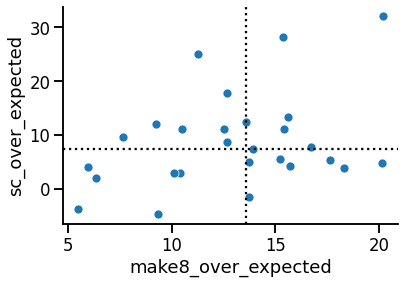

In [ ]:
outs_threshold = 75
text_threshold = 25
df_plt = df_agg.loc[df_agg['outs']>=outs_threshold]
df_text_head = df_plt.sort_values('make8_over_expected', ascending=False).head(text_threshold).merge(df_plt.sort_values('sc_over_expected', ascending=False).head(text_threshold))
df_text_tail = df_plt.sort_values('make8_over_expected', ascending=False).tail(text_threshold).merge(df_plt.sort_values('sc_over_expected', ascending=False).tail(text_threshold))
df_text = df_text_head.append(df_text_tail)

# fig = plt.figure(figsize=(6,4))
fig = sns.scatterplot(x='make8_over_expected', y='sc_over_expected', data=df_plt)

plt.axhline(df_plt.loc[:, 'sc_over_expected'].median(), c='k', ls=':')
plt.axvline(df_plt.loc[:, 'make8_over_expected'].median(), c='k', ls=':')
# texts = [plt.text(row['sc_over_expected'], row['make8_over_expected'], row['guy']) for idx, row in df_text.loc[:, ['sc_over_expected', 'make8_over_expected', 'guy']].iterrows()]
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
sns.despine()
plt.show()

# improve the model  
from a linear model to random forest

In [ ]:
make8_rider_feats = ['year', 'rode%_guy', 'fmounted%', 'frode%',
                     'num85%','rider_left', 'bullpower']
make8_bull_feats = ['power', 'hisc', 'rode%_bull', 'vtgbo%', 'vtgrode%',
                    'vslbo%', 'vslrode%', 'vsrbo%', 'vsrrode%', 'bulldir_left',
                    'bulldir_right', 'bulldir_unknown']
make8_target = 'make8'
make8_model_data = data.loc[:, ['guyid', 'pbid'] + make8_rider_feats + make8_bull_feats + [make8_target]]

sc_rider_feats = ['year', 'rode%_guy', 'fmounted%', 'frode%',
                  'num85%','rider_left', 'bullpower']
sc_bull_feats = ['power', 'hisc', 'rode%_bull', 'vtgbo%', 'vtgrode%',
                 'vslbo%', 'vslrode%', 'vsrbo%', 'vsrrode%', 'bulldir_left',
                 'bulldir_right', 'bulldir_unknown']
sc_target = 'sc'
sc_model_data = data.loc[data['make8']==1, ['guyid', 'pbid'] + sc_rider_feats + sc_bull_feats + [sc_target]]
sc_model_data_holdout = data.loc[data['make8']==0, ['guyid', 'pbid'] + sc_rider_feats + sc_bull_feats + [sc_target]]

rider_folds = make8_model_data[['guyid']].drop_duplicates().sample(frac=1)
rider_folds['rider_fold'] = np.repeat(list(range(10)),round(rider_folds.shape[0]/10, 0))[:rider_folds.shape[0]]

bull_folds = make8_model_data[['pbid']].drop_duplicates().sample(frac=1)
bull_folds['bull_fold'] = np.repeat(list(range(10)),round(bull_folds.shape[0]/10, 0))[:bull_folds.shape[0]]

make8_model_data = make8_model_data.merge(rider_folds).merge(bull_folds)

rider_folds = sc_model_data[['guyid']].drop_duplicates().sample(frac=1)
rider_folds['rider_fold'] = np.repeat(list(range(10)),round(rider_folds.shape[0]/10, 0))[:rider_folds.shape[0]]

bull_folds = sc_model_data[['pbid']].drop_duplicates().sample(frac=1)
bull_folds['bull_fold'] = np.repeat(list(range(10)),round(bull_folds.shape[0]/10, 0))[:bull_folds.shape[0]]

sc_model_data = sc_model_data.merge(rider_folds).merge(bull_folds)

In [ ]:
_df_pred1 = pd.DataFrame()
_df_pred2 = pd.DataFrame()
df_pred = pd.DataFrame()
df_pred2 = pd.DataFrame()

kf = GroupKFold(10)
for train_idx, test_idx in kf.split(make8_model_data, groups=make8_model_data['guyid']):
  train_data = make8_model_data.iloc[train_idx].copy()
  test_data = make8_model_data.iloc[test_idx].copy()

  model = RandomForestClassifier()
  model.fit(train_data.loc[:, make8_rider_feats + make8_bull_feats], train_data[make8_target])
  test_data['make8_prob'] = pd.DataFrame(model.predict_proba(test_data.loc[:, make8_rider_feats + make8_bull_feats]), index=test_data.index)[1]
  _df_pred1 = _df_pred1.append(test_data)

for train_idx, test_idx in kf.split(make8_model_data, groups=make8_model_data['pbid']):
  train_data = make8_model_data.iloc[train_idx].copy()
  test_data = make8_model_data.iloc[test_idx].copy()

  model = RandomForestClassifier()
  model.fit(train_data.loc[:, make8_rider_feats + make8_bull_feats], train_data[make8_target])
  test_data['make8_prob'] = pd.DataFrame(model.predict_proba(test_data.loc[:, make8_rider_feats + make8_bull_feats]), index=test_data.index)[1]
  _df_pred2 = _df_pred2.append(test_data)

rider_r2 = pearsonr(_df_pred1[make8_target], _df_pred1[f"{make8_target}_prob"])[0]**2
bull_r2 = pearsonr(_df_pred2[make8_target], _df_pred2[f"{make8_target}_prob"])[0]**2

if bull_r2>rider_r2:
  weight = 1+(bull_r2 - rider_r2)/rider_r2
  _df_pred1[f"{make8_target}_prob_w"] = _df_pred1[f"{make8_target}_prob"].mul(1)
  _df_pred2[f"{make8_target}_prob_w"] = _df_pred2[f"{make8_target}_prob"].mul(weight)
else:
  weight = 1+(rider_r2 - bull_r2)/bull_r2
  _df_pred1[f"{make8_target}_prob_w"] = _df_pred1[f"{make8_target}_prob"].mul(weight)
  _df_pred2[f"{make8_target}_prob_w"] = _df_pred2[f"{make8_target}_prob"].mul(1)

make8_model_data['make8_prob'] = _df_pred1[f"{make8_target}_prob_w"].add(_df_pred2[f"{make8_target}_prob_w"]).div(weight+1)
make8_model_data['make8_rider_prob'] = _df_pred1[f"{make8_target}_prob"]
make8_model_data['make8_bull_prob'] = _df_pred2[f"{make8_target}_prob"]
make8_model_data['make8_rider_prob_w'] = _df_pred1[f"{make8_target}_prob_w"]
make8_model_data['make8_bull_prob_w'] = _df_pred2[f"{make8_target}_prob_w"]


In [ ]:
_df_pred1 = pd.DataFrame()
_df_pred2 = pd.DataFrame()
df_pred = pd.DataFrame()
df_pred2 = pd.DataFrame()

kf = GroupKFold(10)
for train_idx, test_idx in kf.split(sc_model_data, groups=sc_model_data['guyid']):
  train_data = sc_model_data.iloc[train_idx].copy()
  test_data = sc_model_data.iloc[test_idx].copy()

  model = RandomForestRegressor()
  model.fit(train_data.loc[:, sc_rider_feats + sc_bull_feats], train_data[sc_target])
  test_data[f'{sc_target}_pred'] = pd.Series(model.predict(test_data.loc[:, sc_rider_feats + sc_bull_feats]), index=test_data.index)
  _df_pred1 = _df_pred1.append(test_data)

for train_idx, test_idx in kf.split(sc_model_data, groups=sc_model_data['pbid']):
  train_data = sc_model_data.iloc[train_idx].copy()
  test_data = sc_model_data.iloc[test_idx].copy()

  model = RandomForestRegressor()
  model.fit(train_data.loc[:, sc_rider_feats + sc_bull_feats], train_data[sc_target])
  test_data[f'{sc_target}_pred'] = pd.Series(model.predict(test_data.loc[:, sc_rider_feats + sc_bull_feats]), index=test_data.index)
  _df_pred2 = _df_pred2.append(test_data)

rider_r2 = pearsonr(_df_pred1[sc_target], _df_pred1[f"{sc_target}_pred"])[0]**2
bull_r2 = pearsonr(_df_pred2[sc_target], _df_pred2[f"{sc_target}_pred"])[0]**2

if bull_r2>rider_r2:
  weight = 1+(bull_r2 - rider_r2)/rider_r2
  _df_pred1[f"{sc_target}_pred_w"] = _df_pred1[f"{sc_target}_pred"].mul(1)
  _df_pred2[f"{sc_target}_pred_w"] = _df_pred2[f"{sc_target}_pred"].mul(weight)
else:
  weight = 1+(rider_r2 - bull_r2)/bull_r2
  _df_pred1[f"{sc_target}_pred_w"] = _df_pred1[f"{sc_target}_pred"].mul(weight)
  _df_pred2[f"{sc_target}_pred_w"] = _df_pred2[f"{sc_target}_pred"].mul(1)

sc_model_data['sc_pred'] = _df_pred1[f"{sc_target}_pred_w"].add(_df_pred2[f"{sc_target}_pred_w"]).div(weight+1)
sc_model_data['sc_rider_pred'] = _df_pred1[f"{sc_target}_pred"]
sc_model_data['sc_bull_pred'] = _df_pred2[f"{sc_target}_pred"]
sc_model_data['sc_rider_pred_w'] = _df_pred1[f"{sc_target}_pred_w"]
sc_model_data['sc_bull_pred_w'] = _df_pred2[f"{sc_target}_pred_w"]


model = RandomForestRegressor()
model.fit(sc_model_data.loc[:, sc_rider_feats + sc_bull_feats], sc_model_data[sc_target])
sc_model_data_holdout[f'{sc_target}_pred'] = pd.Series(model.predict(sc_model_data_holdout.loc[:, sc_rider_feats + sc_bull_feats]), index=sc_model_data_holdout.index)
df_pred2 = sc_model_data.append(sc_model_data_holdout)

data = data.merge(make8_model_data)
data['sc_pred'] = df_pred2['sc_pred'] # this line borked before (1/28/21)
data['sc_over_expected'] = data['sc'].sub(data['sc_pred'])
data['make8_over_expected'] = data['make8'].sub(data['make8_prob'])

_agg1 = data.loc[:, ['year','guyid', 'guy', 'sc_over_expected']].groupby(['year','guyid', 'guy'], as_index=False).count().rename(columns={'sc_over_expected':'outs'})
_agg2 = data.loc[data['make8']==1, ['year','guyid', 'guy', 'sc_over_expected', 'make8_over_expected']].groupby(['year','guyid', 'guy'], as_index=False).sum()
df_agg = _agg1.merge(_agg2)
for col in ['sc_over_expected', 'make8_over_expected']:
  df_agg[f"{col}_mean"] = df_agg[col].div(df_agg['outs'])


ValueError: ignored

In [ ]:
make8_model_data.shape

(62412, 29)

In [ ]:
data = data.merge(make8_model_data)
data.head()

,guyid,year,pbid,rid,perf,contestant,sc,ja,jb,time,go,comments,mid,qr,isout,rank,bno,bname,avgmark,mounted_bull,rode_bull,vtgbo,vtgrode,vslbo,vslrode,vsrbo,vsrrode,dirpref,dirperc,power,rode%_bull,vtgbo%,vtgrode%,vslbo%,vslrode%,vsrbo%,vsrrode%,guy,records,mounted_guy,rode_guy,fmounted,frode,num85,hisc,ppo,streak,winperc,bullrank,bullpower,hand,ht,wt,note,pbrid,rode%_guy,fmounted%,frode%,num85%,make8,bulldir_left,bulldir_right,bulldir_unknown,rider_left,make8_prob,sc_pred,sc_over_expected,make8_over_expected,rider_fold,bull_fold,make8_rider_prob,make8_bull_prob,make8_rider_prob_w,make8_bull_prob_w
0,6629,2019,36026,AB445,01,Eduardo Aparecido,0.0,21.75,21.75,0.95,1,*,438632,0,1,953,391,Slingin' Tears,21.499,38,7,19,6,15,7,15,0,left,32.0,85.36,0.184211,0.500000,0.157895,0.394737,0.184211,0.394737,0.000000,Eduardo Aparecido,705,659,304,103,36,184,93.25,84.484,40.00,0.041,3478,75.46,R,68,160,NaN,5420,0.461305,0.156297,0.054628,0.279211,0,1,0,0,0,0.097836,85.213074,-85.213074,-0.097836,2,0,0.172333,0.0375,0.172333,0.046301
1,6629,2020,36026,AB515,01,Eduardo Aparecido,0.0,21.25,21.75,2.18,1,*,451468,0,1,953,391,Slingin' Tears,21.499,38,7,19,6,15,7,15,0,left,32.0,85.36,0.184211,0.500000,0.157895,0.394737,0.184211,0.394737,0.000000,Eduardo Aparecido,705,659,304,103,36,184,93.25,84.484,40.00,0.041,3478,75.46,R,68,160,NaN,5420,0.461305,0.156297,0.054628,0.279211,0,1,0,0,0,0.108892,84.845369,-84.845369,-0.108892,2,0,0.160000,0.0675,0.160000,0.083343
2,5977,2018,40286,AC1129,01,Taylor Toves,0.0,21.50,21.50,5.11,1,*,425737,0,1,5513,L6,Rotten Bananas,20.888,8,0,5,0,3,0,5,0,unknown,0.0,77.42,0.000000,0.625000,0.000000,0.375000,0.000000,0.625000,0.000000,Taylor Toves,664,627,141,76,15,69,91.00,83.484,33.33,0.033,6026,67.06,R,0,0,NaN,5458,0.224880,0.121212,0.023923,0.110048,0,0,0,1,0,0.000000,89.010156,-89.010156,0.000000,6,1,0.000000,0.0000,0.000000,0.000000
3,6085,2017,38285,AC968,01F,Tye Chandler,0.0,20.00,21.50,1.50,F,*,399544,0,1,7683,225,Dew Rag Dan,20.736,9,1,5,1,4,0,4,1,unknown,0.0,71.87,0.111111,0.555556,0.111111,0.444444,0.000000,0.444444,0.111111,Tye Chandler,384,352,90,58,15,39,89.50,83.931,20.00,0.043,5909,65.37,R,0,0,NaN,6602,0.255682,0.164773,0.042614,0.110795,0,0,0,1,0,0.044475,86.168366,-86.168366,-0.044475,8,5,0.050000,0.0400,0.050000,0.049388
4,6385,2018,36574,AB412,02,Cooper Davis,0.0,21.50,21.50,2.14,2,*,417629,0,1,2589,14,Big Kahuna,21.142,26,0,17,0,8,0,18,0,right,0.0,87.43,0.000000,0.653846,0.000000,0.307692,0.000000,0.692308,0.000000,Cooper Davis,911,843,379,137,44,267,93.75,85.363,60.00,0.121,4408,72.48,R,0,0,NaN,5542,0.449585,0.162515,0.052195,0.316726,0,0,1,0,0,0.000000,83.682217,-83.682217,0.000000,2,1,0.000000,0.0000,0.000000,0.000000


In [ ]:
data.shape

(188, 74)

In [ ]:
df_pred2

,guyid,pbid,year,rode%_guy,fmounted%,frode%,num85%,rider_left,bullpower,power,hisc,rode%_bull,vtgbo%,vtgrode%,vslbo%,vslrode%,vsrbo%,vsrrode%,bulldir_left,bulldir_right,bulldir_unknown,sc,rider_fold,bull_fold,sc_pred,sc_rider_pred,sc_bull_pred,sc_rider_pred_w,sc_bull_pred_w
0,6629,39839,2019,0.461305,0.156297,0.054628,0.279211,0,75.46,69.87,93.25,0.344828,0.310345,0.310345,0.241379,0.068966,0.275862,0.275862,0,1,0,82.00,1.0,8.0,85.470792,84.808333,86.249667,99.711882,86.249667
1,8080,39839,2018,0.390805,0.149425,0.045977,0.126437,0,66.47,69.87,88.25,0.344828,0.310345,0.310345,0.241379,0.068966,0.275862,0.275862,0,1,0,81.50,2.0,8.0,84.787418,85.227500,84.270000,100.204710,84.270000
2,8924,39839,2019,0.361111,0.194444,0.046296,0.333333,1,73.26,69.87,93.00,0.344828,0.310345,0.310345,0.241379,0.068966,0.275862,0.275862,0,1,0,88.75,7.0,8.0,86.638337,86.164167,87.195833,101.305979,87.195833
3,6668,39839,2018,0.364570,0.127086,0.034660,0.211810,0,68.88,69.87,94.50,0.344828,0.310345,0.310345,0.241379,0.068966,0.275862,0.275862,0,1,0,86.50,2.0,8.0,86.887954,86.743750,87.057500,101.987414,87.057500
4,690,39839,2018,0.333333,0.158206,0.041455,0.182741,0,69.90,69.87,92.00,0.344828,0.310345,0.310345,0.241379,0.068966,0.275862,0.275862,0,1,0,83.75,7.0,8.0,86.126748,86.085000,86.175833,101.212900,86.175833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62407,9320,43664,2020,0.000000,0.000000,0.000000,0.000000,1,74.96,74.96,0.00,0.000000,0.142857,0.000000,0.142857,0.000000,0.000000,0.000000,0,0,1,0.00,NaN,NaN,70.125000,NaN,NaN,NaN,NaN
62408,9252,43722,2020,0.000000,0.000000,0.000000,0.000000,1,41.82,41.82,0.00,0.166667,0.000000,0.000000,0.166667,0.166667,0.166667,0.000000,0,0,1,0.00,NaN,NaN,70.480000,NaN,NaN,NaN,NaN
62409,9274,24468,2020,0.000000,0.000000,0.000000,0.000000,1,38.12,38.12,0.00,0.529412,0.000000,0.117647,0.117647,0.294118,0.117647,0.176471,1,0,0,0.00,NaN,NaN,69.850000,NaN,NaN,NaN,NaN
62410,9298,44490,2020,0.000000,0.000000,0.000000,0.000000,1,38.29,37.49,0.00,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0,0,1,0.00,NaN,NaN,70.710000,NaN,NaN,NaN,NaN


the beta linear model  
$rmse$: 4.11  
$R^2$: 0.181  

In [ ]:
print('the chad random forest\n\n')
print('logloss')
print(log_loss(make8_model_data[make8_target], np.repeat([make8_model_data[make8_target].mean()],
                                          make8_model_data[make8_target].shape[0])))
print(f"""please bro: {log_loss(make8_model_data[make8_target], make8_model_data[f"{make8_target}_prob"])}\n""")
print('acc')
print(accuracy_score(make8_model_data[make8_target], np.round(np.repeat([make8_model_data[make8_target].mean()],
                                          make8_model_data[make8_target].shape[0]))))
print(f"""pleaseee: {accuracy_score(make8_model_data[make8_target], make8_model_data[f"{make8_target}_prob"].round(0))}""")

rmse = mean_squared_error(data.loc[data['make8']==1, sc_target], data.loc[data['make8']==1, f"{sc_target}_pred"])**0.5
r2 = pearsonr(data.loc[data['make8']==1, sc_target], data.loc[data['make8']==1, f"{sc_target}_pred"])[0]**2
print(f"rmse: {rmse}")
print(f"r2: {r2}")

In [ ]:
outs_threshold = 0
text_threshold = 25
df_plt = df_agg.loc[df_agg['outs']>=outs_threshold]
df_text_head = df_plt.sort_values('make8_over_expected', ascending=False).head(text_threshold).merge(df_plt.sort_values('sc_over_expected', ascending=False).head(text_threshold))
df_text_tail = df_plt.sort_values('make8_over_expected', ascending=False).tail(text_threshold).merge(df_plt.sort_values('sc_over_expected', ascending=False).tail(text_threshold))
df_text = df_text_head.append(df_text_tail)

# fig = sns.regplot(x='make8_over_expected', y='sc_over_expected', data=df_plt, scatter=False, color='k')
fig = sns.scatterplot(x='make8_over_expected', y='sc_over_expected', data=df_plt)

plt.axhline(df_plt.loc[:, 'sc_over_expected'].median(), c='k', ls=':')
plt.axvline(df_plt.loc[:, 'make8_over_expected'].median(), c='k', ls=':')
sns.despine()
plt.show()

In [ ]:
df_plt.loc[:, ['sc_over_expected', 'make8_over_expected']].describe()

In [ ]:
df_plt.sort_values("sc_over_expected", ascending=False)

,year,guyid,guy,outs,sc_over_expected,make8_over_expected,sc_over_expected_mean,make8_over_expected_mean
1744,2019,7721,Jess Lockwood,109,314.162820,53.017223,2.882228,0.486397
2136,2020,8288,Jose Vitor Leme,91,241.021822,41.165851,2.648591,0.452372
1828,2019,8288,Jose Vitor Leme,128,237.772413,49.306511,1.857597,0.385207
1570,2019,5146,Chase Outlaw,149,204.338792,55.360916,1.371401,0.371550
1480,2018,8288,Jose Vitor Leme,84,158.378699,28.186871,1.885461,0.335558
...,...,...,...,...,...,...,...,...
1130,2017,8099,Claudio Montanha Jr.,94,-67.717167,35.683421,-0.720395,0.379611
1230,2018,5251,Silvano Alves,96,-73.900289,25.525181,-0.769795,0.265887
1682,2019,7081,Shay Marks,86,-81.807667,14.211965,-0.951252,0.165255
902,2017,5580,Matt Triplett,89,-82.129583,28.864548,-0.922804,0.324321


## same thing but for bulls now

In [ ]:
_agg1 = data.loc[:, ['pbid', 'bname', 'sc_over_expected']].groupby(['pbid', 'bname'], as_index=False).count().rename(columns={'sc_over_expected':'outs'})
_agg2 = data.loc[data['make8']==1, ['pbid', 'bname', 'sc_over_expected', 'make8_over_expected']].groupby(['pbid', 'bname'], as_index=False).sum()
df_agg = _agg1.merge(_agg2)
for col in ['sc_over_expected', 'make8_over_expected']:
  df_agg[f"{col}_mean"] = df_agg[col].div(df_agg['outs'])

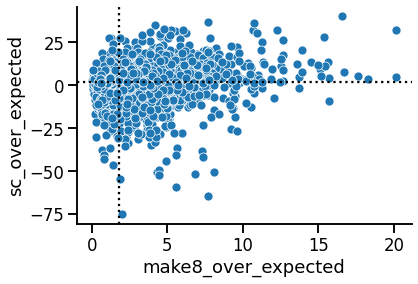

In [ ]:
outs_threshold = 0
text_threshold = 25
df_plt = df_agg.loc[df_agg['outs']>=outs_threshold]
df_text_head = df_plt.sort_values('make8_over_expected', ascending=False).head(text_threshold).merge(df_plt.sort_values('sc_over_expected', ascending=False).head(text_threshold))
df_text_tail = df_plt.sort_values('make8_over_expected', ascending=False).tail(text_threshold).merge(df_plt.sort_values('sc_over_expected', ascending=False).tail(text_threshold))
df_text = df_text_head.append(df_text_tail)

# fig = sns.regplot(x='make8_over_expected', y='sc_over_expected', data=df_plt, scatter=False, color='k')
fig = sns.scatterplot(x='make8_over_expected', y='sc_over_expected', data=df_plt)

plt.axhline(df_plt.loc[:, 'sc_over_expected'].median(), c='k', ls=':')
plt.axvline(df_plt.loc[:, 'make8_over_expected'].median(), c='k', ls=':')
sns.despine()
plt.show()

,sc_over_expected
count,3495.000000
mean,1.279091
std,9.359543
min,-75.190000
25%,-2.512500
50%,1.957500
75%,6.089250
max,39.983583


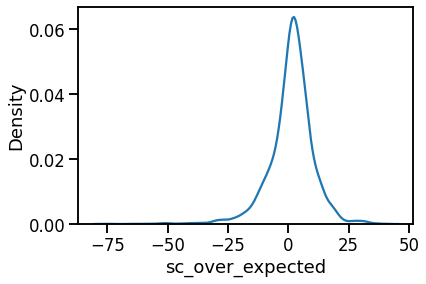

In [ ]:
sns.kdeplot(df_plt['sc_over_expected'])
df_plt[['sc_over_expected']].describe()

count    3495.000000
mean       16.871531
std        13.179416
min         2.000000
25%         8.000000
50%        13.000000
75%        22.000000
max       118.000000
Name: outs, dtype: float64

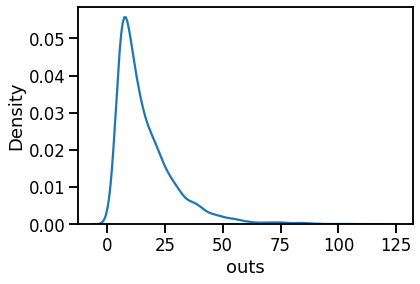

In [ ]:
sns.kdeplot(df_plt['outs'])
df_plt['outs'].describe()

In [ ]:
df_plt.loc[df_plt['bname']=="Chiseled"]

,pbid,bname,outs,sc_over_expected,make8_over_expected,sc_over_expected_mean,make8_over_expected_mean
2636,40393,Chiseled,40,20.152188,6.181333,0.503805,0.154533


In [ ]:
df_plt.sort_values('sc_over_expected', ascending=False).head(20)

,pbid,bname,outs,sc_over_expected,make8_over_expected,sc_over_expected_mean,make8_over_expected_mean
324,30537,Minion Stuart,71,39.983583,16.536500,0.563149,0.232908
529,32174,Painkiller,35,36.543095,7.699333,1.044088,0.219981
713,33412,Red Cloud,50,35.898875,10.722333,0.717978,0.214447
728,33485,Too Juicy,21,34.735083,4.204833,1.654052,0.200230
2436,39876,Powerstroke,20,32.832083,4.755500,1.641604,0.237775
251,29776,Yellowhair,71,32.198524,12.231833,0.453500,0.172279
2355,39617,Concealed Carry,35,32.032042,6.038190,0.915201,0.172520
426,31396,SweetPro's Bruiser,118,31.979923,20.169012,0.271016,0.170924
1131,35343,Big Baby,26,31.975000,5.269333,1.229808,0.202667
176,28363,Karaoke,41,31.891458,10.670500,0.777840,0.260256
